# Computer Vision Lab - Getting started with CNNs

This notebook covers:

1. Creating a CNN to classify the MNIST dataset.
2. Creating a MLP to classify the MNIST dataset.
3. Comparison of the two networks
4. Comparison of their loss and accuracy curves
5. Comparison of how they train on randomized pixels 

## Imports

In [1]:
import torch
import os
import sys

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from torchvision import datasets, transforms
from sklearn.metrics import classification_report

# importing helpers 
sys.path.insert(1, os.pardir)
from src.helpers import count_parameters, plot_train_test_loss

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading MNIST

In [3]:
root_dir = os.path.join(os.pardir, 'data')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

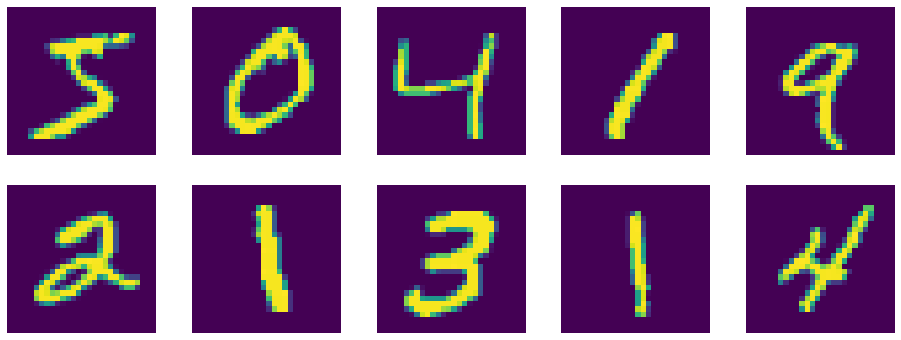

In [4]:
# The MNIST dataset is the handwritten dataset.
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## Creating the Model Classes 

### CNN Model Class

Adapted from example provided. Removed some unused parameters and made the code generally cleaner. 

Calculating outputs of layers ([maths walk through](https://cs231n.github.io/convolutional-networks/#layers)):

Input image: 28*28\*1

Conv 1: 
- K=6 (n_features)
- F=5 
- S=1
- P=0
  
Using: $((W - F +2P)/S) + 1$

Output of Conv 1:
- $W_2$ = ((28-5)/1)+1 = 24
- $H_2$ = ((28-5)/1)+1 = 24
- $D_2$ = 6

Pooling 1:
- K=2
- S=2
- P=0

Output from pooling of Conv 1:
- $W_3$ = ((24-2)/2)+1 = 12
- $H_3$ = ((24-2)/2)+1 = 12
- $D_3$ = 6

Conv 2: 
- K=6 (n_features)
- F=5 
- S=1
- P=0

Output of Conv 1:
- $W_4$ = ((12-5)/1)+1 = 8
- $H_4$ = ((12-5)/1)+1 = 8
- $D_4$ = 6

Pooling 2:
- K=2
- S=2
- P=0

Output from pooling of Conv 2:
- $W_5$ = ((8-2)/2)+1 = 4
- $H_5$ = ((8-2)/2)+1 = 4
- $D_5$ = 6

Final volume after 2 convolution-pooling blocks: 4*4\*6 

In [5]:
class CNN(nn.Module):
    def __init__(self, n_feature):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        # First convolutional layer (sees 24x24x1 tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        # Second convolutional layer (sees 12x12x6 tensor)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5)
        
        self.flatten = nn.Flatten()
        # Linear Layer (4*4*6 -> 50)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        # Linear Layer (50 -> 10)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        # First convolution-pooling block 
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) # stride = kernel_size
        # Tensor volume: [64,6,12,12]
        
        # Second convolution-pooling block
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) 
        # [64, 6, 4, 4]
        
        # Fully connected layer
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

cnn_model = CNN(6)
print(cnn_model)
count_parameters(cnn_model)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
+--------------+-----------+------------+
|   Modules    | Trainable | Parameters |
+--------------+-----------+------------+
| conv1.weight |    True   |    150     |
|  conv1.bias  |    True   |     6      |
| conv2.weight |    True   |    900     |
|  conv2.bias  |    True   |     6      |
|  fc1.weight  |    True   |    4800    |
|   fc1.bias   |    True   |     50     |
|  fc2.weight  |    True   |    500     |
|   fc2.bias   |    True   |     10     |
+--------------+-----------+------------+
Trainable Params: 6422 of 6422 total params


### MLP Model Class

In [7]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
mlp_model = MLP()
print(mlp_model)
count_parameters(mlp_model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
+------------+-----------+------------+
|  Modules   | Trainable | Parameters |
+------------+-----------+------------+
| fc1.weight |    True   |   39200    |
|  fc1.bias  |    True   |     50     |
| fc2.weight |    True   |    2500    |
|  fc2.bias  |    True   |     50     |
| fc3.weight |    True   |    500     |
|  fc3.bias  |    True   |     10     |
+------------+-----------+------------+
Trainable Params: 42310 of 42310 total params


## Defining Training and testing functions 

Adapted from example provided.

In [7]:
def train(model, optimizer, verbose=True, print_freq=450):

    epoch_loss = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device) # [64, 1, 28, 28]

        optimizer.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*data.size(0)
        
        if batch_idx % print_freq == 0 & verbose:
            processed = (batch_idx) * len(data)
            percent = 100. * (batch_idx) / len(train_loader)
            print(f'Train step: {batch_idx+1} [{processed}/{len(train_loader.dataset)} ({percent:.0f}%)]\tLoss: {loss.item():.6f}')

    return epoch_loss/len(train_loader.dataset)

def test(model):
    
    model.eval()

    test_loss = 0
    correct = 0

    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)

        test_loss += F.nll_loss(output, target).item() * len(data) 
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')

    return (test_loss, accuracy)

def train_test(model, device, optimizer, epochs):
    model.to(device)
    train_losses = []
    test_losses = []
    test_accuracies = []
    for epoch in range(0, epochs):
        print(f'Epoch: {epoch +1}/{epochs}')
        train_losses.append(train(model, optimizer))
        test_loss, test_accuracy = test(model)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    return {'train_losses': train_losses, 'test_losses': test_losses, 'test_accuracies': test_accuracies}


 ## Training Models

In [8]:
# Common training hyper parameters 
epochs = 20

### Training CNN

In [9]:
cnn_model = CNN(6)
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.5)
cnn_metrics = train_test(cnn_model, device, optimizer, epochs)

Epoch: 1/20
Train step: 1 [0/60000 (0%)]	Loss: 2.292509
Train step: 451 [28800/60000 (48%)]	Loss: 0.407586
Train step: 901 [57600/60000 (96%)]	Loss: 0.267780
Test set: Average loss: 0.1870, Accuracy: 9422/10000 (94%)
Epoch: 2/20
Train step: 1 [0/60000 (0%)]	Loss: 0.211715
Train step: 451 [28800/60000 (48%)]	Loss: 0.053365
Train step: 901 [57600/60000 (96%)]	Loss: 0.156655
Test set: Average loss: 0.1029, Accuracy: 9677/10000 (97%)
Epoch: 3/20
Train step: 1 [0/60000 (0%)]	Loss: 0.091022
Train step: 451 [28800/60000 (48%)]	Loss: 0.062786
Train step: 901 [57600/60000 (96%)]	Loss: 0.116110
Test set: Average loss: 0.0843, Accuracy: 9719/10000 (97%)
Epoch: 4/20
Train step: 1 [0/60000 (0%)]	Loss: 0.152172
Train step: 451 [28800/60000 (48%)]	Loss: 0.037145
Train step: 901 [57600/60000 (96%)]	Loss: 0.039481
Test set: Average loss: 0.0766, Accuracy: 9749/10000 (97%)
Epoch: 5/20
Train step: 1 [0/60000 (0%)]	Loss: 0.013668
Train step: 451 [28800/60000 (48%)]	Loss: 0.052857
Train step: 901 [57600/60

In [10]:
plot_train_test_loss(cnn_metrics['train_losses'], cnn_metrics['test_losses'], 'CNN training & test loss')

In [11]:
fig = px.line(y=cnn_metrics['test_accuracies'], x=list(range(1,epochs+1)), labels={'y':'Accuracy', 'x':'Epoch'})
fig.update_layout(title='CNN accuracy', showlegend=False)
fig.show()

### Training MLP

In [12]:
mlp_model = MLP()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.5)
mlp_metrics = train_test(mlp_model, device, optimizer, epochs)

Epoch: 1/20
Train step: 1 [0/60000 (0%)]	Loss: 2.331157
Train step: 451 [28800/60000 (48%)]	Loss: 0.375267
Train step: 901 [57600/60000 (96%)]	Loss: 0.220202
Test set: Average loss: 0.2963, Accuracy: 9101/10000 (91%)
Epoch: 2/20
Train step: 1 [0/60000 (0%)]	Loss: 0.209529
Train step: 451 [28800/60000 (48%)]	Loss: 0.299072
Train step: 901 [57600/60000 (96%)]	Loss: 0.408460
Test set: Average loss: 0.2273, Accuracy: 9328/10000 (93%)
Epoch: 3/20
Train step: 1 [0/60000 (0%)]	Loss: 0.173975
Train step: 451 [28800/60000 (48%)]	Loss: 0.138614
Train step: 901 [57600/60000 (96%)]	Loss: 0.200063
Test set: Average loss: 0.1865, Accuracy: 9455/10000 (95%)
Epoch: 4/20
Train step: 1 [0/60000 (0%)]	Loss: 0.258829
Train step: 451 [28800/60000 (48%)]	Loss: 0.157487
Train step: 901 [57600/60000 (96%)]	Loss: 0.118170
Test set: Average loss: 0.1579, Accuracy: 9530/10000 (95%)
Epoch: 5/20
Train step: 1 [0/60000 (0%)]	Loss: 0.143948
Train step: 451 [28800/60000 (48%)]	Loss: 0.181689
Train step: 901 [57600/60

In [13]:
plot_train_test_loss(mlp_metrics['train_losses'], mlp_metrics['test_losses'], 'MLP training & test loss')

In [14]:
fig = px.line(y=mlp_metrics['test_accuracies'], x=list(range(1,epochs+1)), labels={'y':'Accuracy', 'x':'Epoch'})
fig.update_layout(title='MLP accuracy', showlegend=False)
fig.show()

## Comparing MLP models and CNN 

In [15]:
fig = go.Figure()
epochs_index = list(range(1,epochs+1))

fig.add_trace(go.Scatter(
    y=mlp_metrics['test_accuracies'],
    x=epochs_index,
    name='MLP train accuracy'
))

fig.add_trace(go.Scatter(
    y=cnn_metrics['test_accuracies'],
    x=epochs_index,
    name='CNN test accuracy'
))

fig.update_layout(
    title='CNN vs MLP accuracy',
    xaxis_title="Epochs")

fig.show()

### Testing the Models

In [16]:
def get_test_results(model):

    y_score = torch.zeros(0,dtype=torch.long, device=device)
    y_test = torch.zeros(0,dtype=torch.long, device=device)

    model.eval()

    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)

        y_score = torch.cat([y_score,preds.view(-1)])
        y_test = torch.cat([y_test,target.view(-1)])
    return y_test, y_score



### SciKit Classification reports

#### MLP report 

In [17]:
y_test, y_score = get_test_results(mlp_model)
print(classification_report(y_test.cpu(), y_score.cpu()))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [18]:
y_test, y_score = get_test_results(cnn_model)
print(classification_report(y_test.cpu(), y_score.cpu()))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.99      0.98       892
           6       0.98      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Experiment - What happens when the data does not make sense anymore 
All assumptions are removed

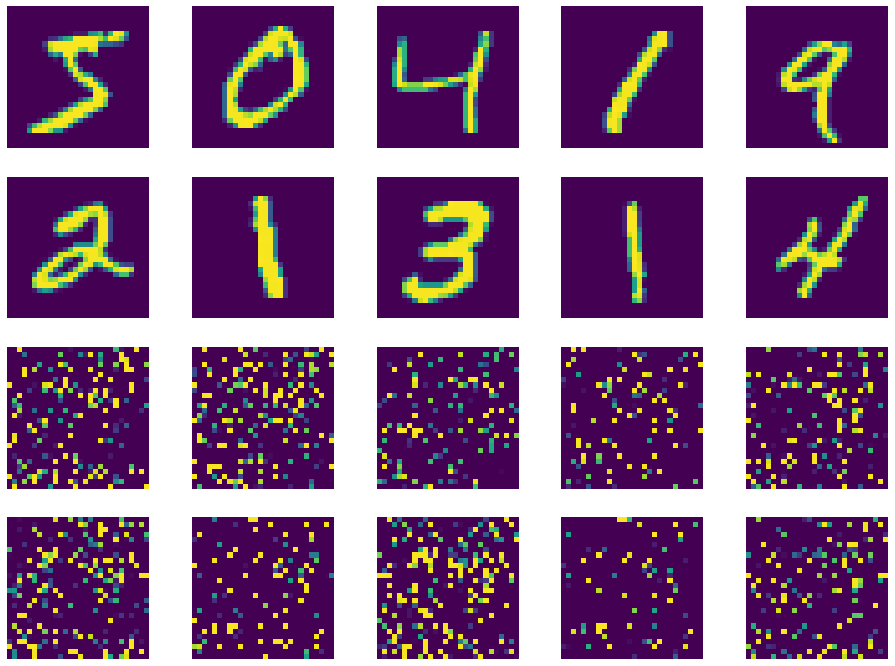

In [19]:

perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset[i]
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

### Train and test functions 

In [20]:
def perm_train(model, optimizer, device, perm, verbose=True, print_freq=450):

    epoch_loss = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device) # [64, 1, 28, 28]

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)


        optimizer.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*data.size(0)
        
        if batch_idx % print_freq == 0 & verbose:
            processed = (batch_idx) * len(data)
            percent = 100. * (batch_idx) / len(train_loader)
            print(f'Train step: {batch_idx+1} [{processed}/{len(train_loader.dataset)} ({percent:.0f}%)]\tLoss: {loss.item():.6f}')

    return epoch_loss/len(train_loader.dataset)

def perm_test(model, device, perm):
    
    model.eval()

    test_loss = 0
    correct = 0

    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)

        test_loss += F.nll_loss(output, target).item() * len(data) 
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')

    return (test_loss, accuracy)

def perm_train_test(model, device, optimizer, perm, epochs):
    model.to(device)
    train_losses = []
    test_losses = []
    test_accuracies = []
    for epoch in range(0, epochs):
        print(f'Epoch: {epoch +1}/{epochs}')
        train_losses.append(perm_train(model, optimizer, device, perm))
        test_loss, test_accuracy = perm_test(model, device, perm)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    return {'train_losses': train_losses, 'test_losses': test_losses, 'test_accuracies': test_accuracies}

### Training on permuted data

In [21]:
# Common training hyper parameters 
epochs = 20

#### Training MLP

In [22]:
mlp_model = MLP()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.5)
mlp_metrics = perm_train_test(mlp_model, device, optimizer, perm, epochs)

Epoch: 1/20
Train step: 1 [0/60000 (0%)]	Loss: 2.329479
Train step: 451 [28800/60000 (48%)]	Loss: 0.430739
Train step: 901 [57600/60000 (96%)]	Loss: 0.204642
Test set: Average loss: 0.2868, Accuracy: 9153/10000 (92%)
Epoch: 2/20
Train step: 1 [0/60000 (0%)]	Loss: 0.261756
Train step: 451 [28800/60000 (48%)]	Loss: 0.305463
Train step: 901 [57600/60000 (96%)]	Loss: 0.375741
Test set: Average loss: 0.2289, Accuracy: 9313/10000 (93%)
Epoch: 3/20
Train step: 1 [0/60000 (0%)]	Loss: 0.144186
Train step: 451 [28800/60000 (48%)]	Loss: 0.337972
Train step: 901 [57600/60000 (96%)]	Loss: 0.386873
Test set: Average loss: 0.1907, Accuracy: 9418/10000 (94%)
Epoch: 4/20
Train step: 1 [0/60000 (0%)]	Loss: 0.172020
Train step: 451 [28800/60000 (48%)]	Loss: 0.218149
Train step: 901 [57600/60000 (96%)]	Loss: 0.227561
Test set: Average loss: 0.1724, Accuracy: 9483/10000 (95%)
Epoch: 5/20
Train step: 1 [0/60000 (0%)]	Loss: 0.185924
Train step: 451 [28800/60000 (48%)]	Loss: 0.190682
Train step: 901 [57600/60

#### Training CNN

In [23]:
cnn_model = CNN(6)
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.5)
cnn_metrics = perm_train_test(cnn_model, device, optimizer, perm, epochs)

Epoch: 1/20
Train step: 1 [0/60000 (0%)]	Loss: 2.299959
Train step: 451 [28800/60000 (48%)]	Loss: 1.191806
Train step: 901 [57600/60000 (96%)]	Loss: 0.450979
Test set: Average loss: 0.5276, Accuracy: 8323/10000 (83%)
Epoch: 2/20
Train step: 1 [0/60000 (0%)]	Loss: 0.596373
Train step: 451 [28800/60000 (48%)]	Loss: 0.559842
Train step: 901 [57600/60000 (96%)]	Loss: 0.575049
Test set: Average loss: 0.3895, Accuracy: 8788/10000 (88%)
Epoch: 3/20
Train step: 1 [0/60000 (0%)]	Loss: 0.378589
Train step: 451 [28800/60000 (48%)]	Loss: 0.333043
Train step: 901 [57600/60000 (96%)]	Loss: 0.407116
Test set: Average loss: 0.3354, Accuracy: 8949/10000 (89%)
Epoch: 4/20
Train step: 1 [0/60000 (0%)]	Loss: 0.314578
Train step: 451 [28800/60000 (48%)]	Loss: 0.316161
Train step: 901 [57600/60000 (96%)]	Loss: 0.434630
Test set: Average loss: 0.2830, Accuracy: 9133/10000 (91%)
Epoch: 5/20
Train step: 1 [0/60000 (0%)]	Loss: 0.404866
Train step: 451 [28800/60000 (48%)]	Loss: 0.212439
Train step: 901 [57600/60

### Evaluating results

In [24]:
plot_train_test_loss(mlp_metrics['train_losses'], mlp_metrics['test_losses'], 'MLP training & test loss')

In [25]:
plot_train_test_loss(cnn_metrics['train_losses'], cnn_metrics['test_losses'], 'CNN training & test loss')

In [26]:
fig = go.Figure()
epochs_index = list(range(1,epochs+1))

fig.add_trace(go.Scatter(
    y=mlp_metrics['test_accuracies'],
    x=epochs_index,
    name='MLP train accuracy'
))

fig.add_trace(go.Scatter(
    y=cnn_metrics['test_accuracies'],
    x=epochs_index,
    name='CNN test accuracy'
))

fig.update_layout(
    title='CNN vs MLP accuracy',
    xaxis_title="Epochs")

fig.show()

In [27]:
y_test, y_score = get_test_results(mlp_model)
print(classification_report(y_test.cpu(), y_score.cpu()))

              precision    recall  f1-score   support

           0       0.03      0.01      0.01       980
           1       0.04      0.00      0.01      1135
           2       0.08      0.01      0.01      1032
           3       0.18      0.65      0.28      1010
           4       0.12      0.04      0.06       982
           5       0.10      0.18      0.13       892
           6       0.00      0.00      0.00       958
           7       0.03      0.02      0.02      1028
           8       0.11      0.07      0.09       974
           9       0.17      0.42      0.24      1009

    accuracy                           0.14     10000
   macro avg       0.09      0.14      0.09     10000
weighted avg       0.08      0.14      0.08     10000



In [28]:
y_test, y_score = get_test_results(cnn_model)
print(classification_report(y_test.cpu(), y_score.cpu()))

              precision    recall  f1-score   support

           0       0.01      0.02      0.01       980
           1       0.00      0.00      0.00      1135
           2       0.03      0.00      0.01      1032
           3       0.08      0.05      0.06      1010
           4       0.13      0.06      0.08       982
           5       0.04      0.00      0.00       892
           6       0.11      0.02      0.03       958
           7       0.04      0.19      0.07      1028
           8       0.04      0.04      0.04       974
           9       0.18      0.21      0.20      1009

    accuracy                           0.06     10000
   macro avg       0.07      0.06      0.05     10000
weighted avg       0.07      0.06      0.05     10000

